In [20]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt

In [2]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.3.5 scikit-learn==1.2.1 statsmodels==0.13.5 pynndescent==0.5.10


In [3]:
DATA_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23spring/0301_AAE/benchmark/real_datasets/raw_h5ad/'

In [4]:
META_PATH = '/gpfs/gibbs/pi/gerstein/cz357/23spring/0301_AAE/benchmark/real_datasets/metadata/'

In [5]:
meta = pd.read_csv(META_PATH+'GSE96583_batch2.total.tsne.df.tsv.gz', sep='\t')
meta.head()

,tsne1,tsne2,ind,stim,cluster,cell,multiplets
AAACATACAATGCC-1,-4.277833,-19.294709,107,ctrl,5,CD4 T cells,doublet
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet
AAACATACCAGCTA-1,-28.132584,24.925484,1256,ctrl,9,CD14+ Monocytes,doublet
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet


In [6]:
celltype_mapping = meta['cell'].to_dict()

In [7]:
adata = sc.read_h5ad(DATA_PATH+'pbmc-2ctrl-dm.h5ad.gz')
adata

AnnData object with n_obs × n_vars = 13913 × 17584
    obs: 'doublet_label'

In [8]:
adata.obs['celltype'] = adata.obs_names.map(celltype_mapping)
adata.obs['celltype'].value_counts()

CD4 T cells          5636
CD14+ Monocytes      3255
B cells              1442
CD8 T cells          1328
NK cells             1011
FCGR3A+ Monocytes     882
Dendritic cells       223
Megakaryocytes        136
Name: celltype, dtype: int64

In [9]:
adata.obs

,doublet_label,celltype
AAACATACAATGCC-1,doublet,CD4 T cells
AAACATACATTTCC-1,singlet,CD14+ Monocytes
AAACATACCAGAAA-1,singlet,CD14+ Monocytes
AAACATACCAGCTA-1,doublet,CD14+ Monocytes
AAACATACCATGCA-1,singlet,CD4 T cells
...,...,...
TTTGCATGCTTCGC-1,singlet,B cells
TTTGCATGGCAGTT-1,singlet,FCGR3A+ Monocytes
TTTGCATGGGAACG-1,singlet,CD8 T cells
TTTGCATGGTCCTC-1,singlet,B cells


In [10]:
np.random.seed(1)
n_cells = 8000
selected_cells = np.random.choice(adata.obs_names, size=n_cells, replace=False)

In [11]:
np.random.seed(1)
n_doublets = n_cells // 2 
generated_doublets = np.random.choice(selected_cells, size=(n_doublets, 2), replace=False)

In [12]:
np.random.seed(1)
doublet_data = []
for cell1, cell2 in generated_doublets:
    # scale_ratio = np.random.uniform(0.8, 1) # generate a random fraction of reads to lose
    cell1_data = adata.X[adata.obs_names == cell1][0]
    cell2_data = adata.X[adata.obs_names == cell2][0]
    n_genes = cell1_data.shape[0]
    missing_frac = np.random.normal(loc=0.15, scale=0.04) # generate a random fraction of genes to lose
    missing_genes1 = np.random.choice(n_genes, size=int(n_genes * missing_frac), replace=False)
    missing_genes2 = np.random.choice(n_genes, size=int(n_genes * missing_frac), replace=False)
    cell1_data[missing_genes1] = 0
    cell2_data[missing_genes2] = 0
    # combined_data = (cell1_data + cell2_data) * scale_ratio
    combined_data = cell1_data + cell2_data
    doublet_data.append(combined_data)

In [13]:
doublet_adata = sc.AnnData(np.vstack(doublet_data), obs={'doublet_label': 'generated'})
doublet_adata.obs_names = [f'doublet{i}' for i in range(n_doublets)]
doublet_adata.var = adata.var.copy()

In [14]:
adata_merged = adata.concatenate(doublet_adata)
adata_merged

/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 17913 × 17584
    obs: 'doublet_label', 'celltype', 'batch'

In [15]:
sc.pp.filter_cells(adata_merged, min_genes=200)
sc.pp.filter_genes(adata_merged, min_cells=3)

filtered out 60 cells that have less than 200 genes expressed
filtered out 2096 genes that are detected in less than 3 cells


In [16]:
adata_merged.obs['doublet_label'].value_counts()

singlet      12261
generated     4000
doublet       1592
Name: doublet_label, dtype: int64

In [17]:
sc.pp.calculate_qc_metrics(adata_merged, percent_top=None, log1p=False, inplace=True)

In [18]:
fig_dir = '/gpfs/gibbs/project/gerstein/cz357/23spring/2304_AAE/fig/'

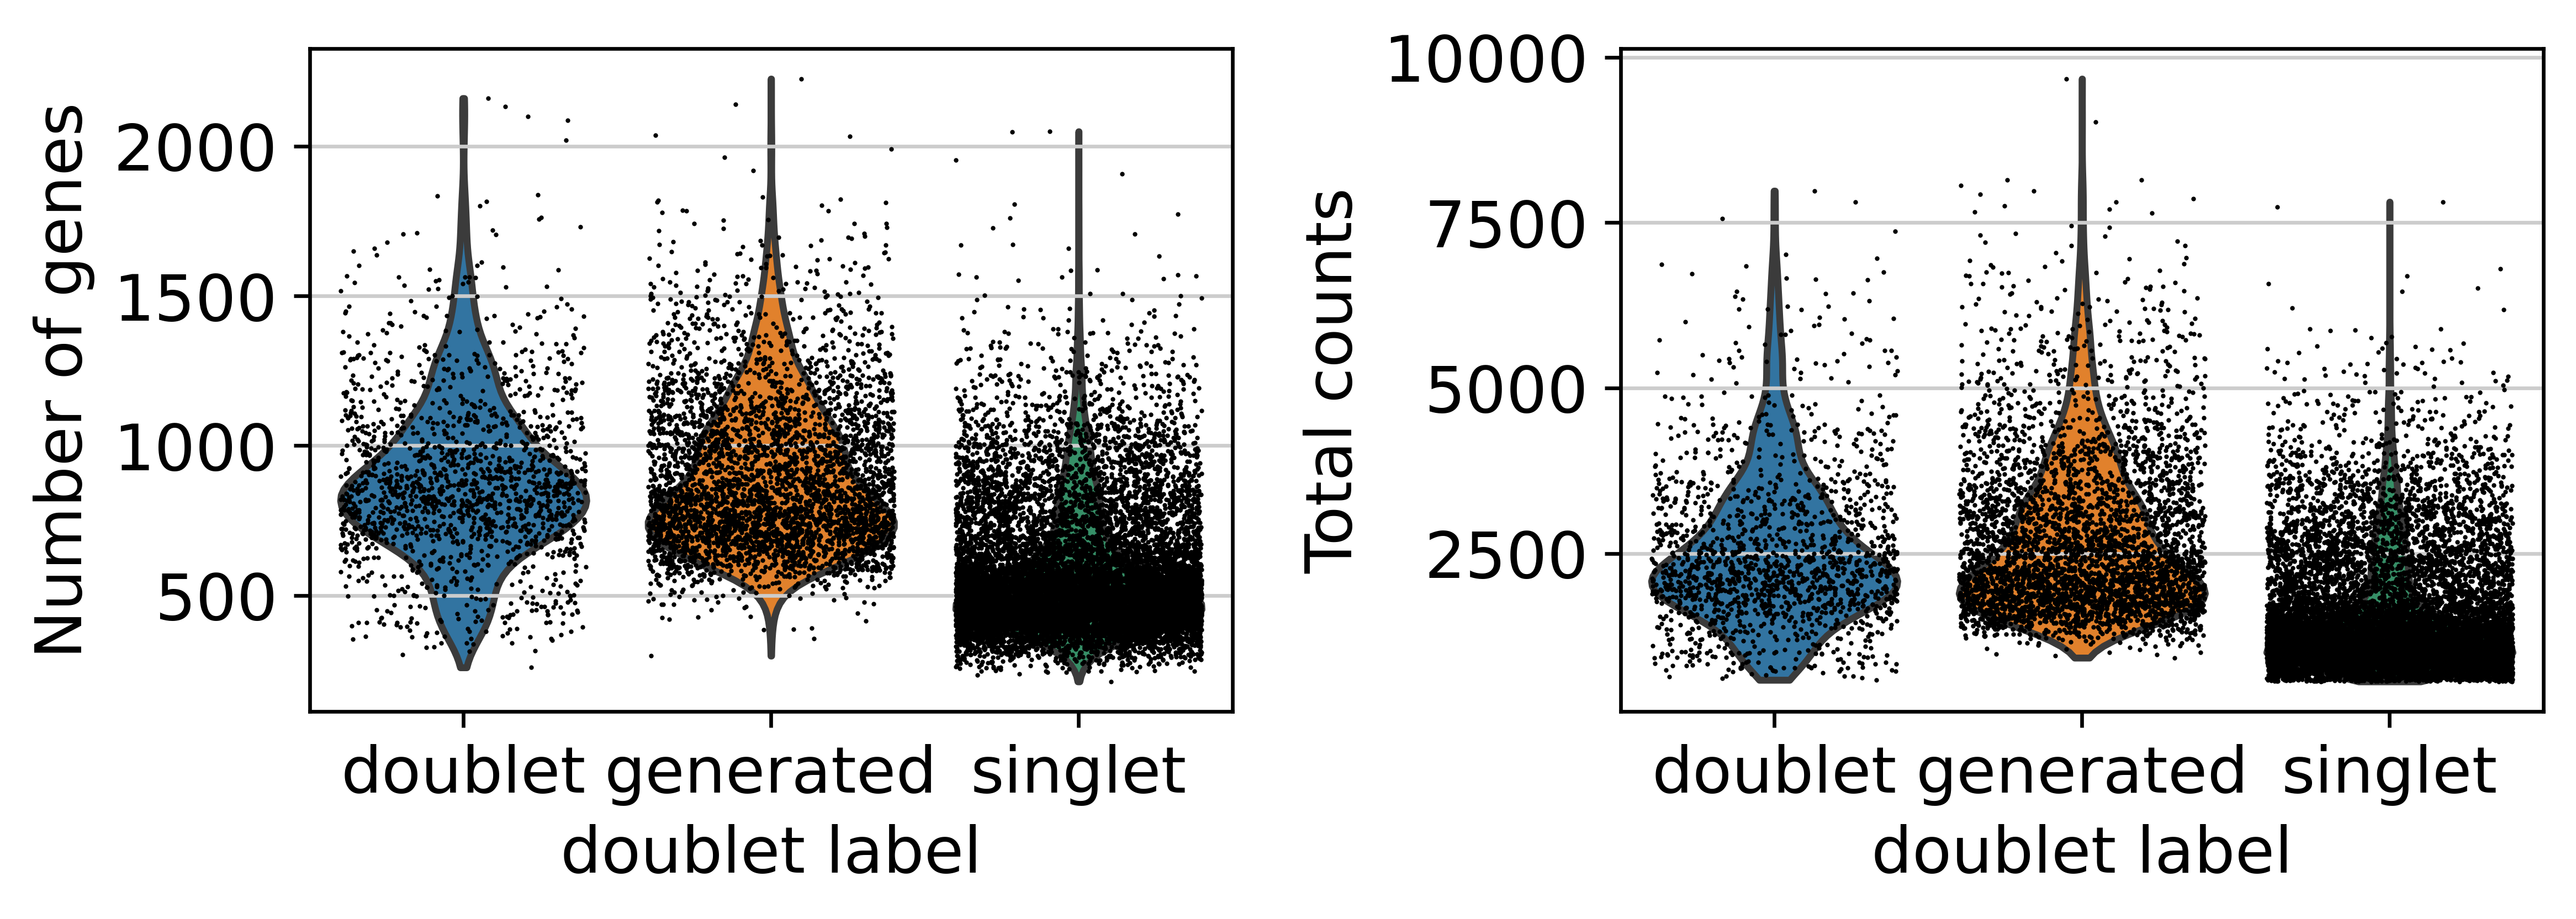

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.violin(adata_merged, ['n_genes_by_counts'], jitter=0.4, 
             groupby='doublet_label', ax=axs[0], show=False)
sc.pl.violin(adata_merged, ['total_counts'], jitter=0.4, 
             groupby='doublet_label', ax=axs[1], show=False)
axs[0].set_ylabel('Number of genes')
axs[1].set_ylabel('Total counts')
fig.tight_layout()
fig.savefig(fig_dir+'1.fake_doublets_violin.png', bbox_inches='tight')
plt.show()

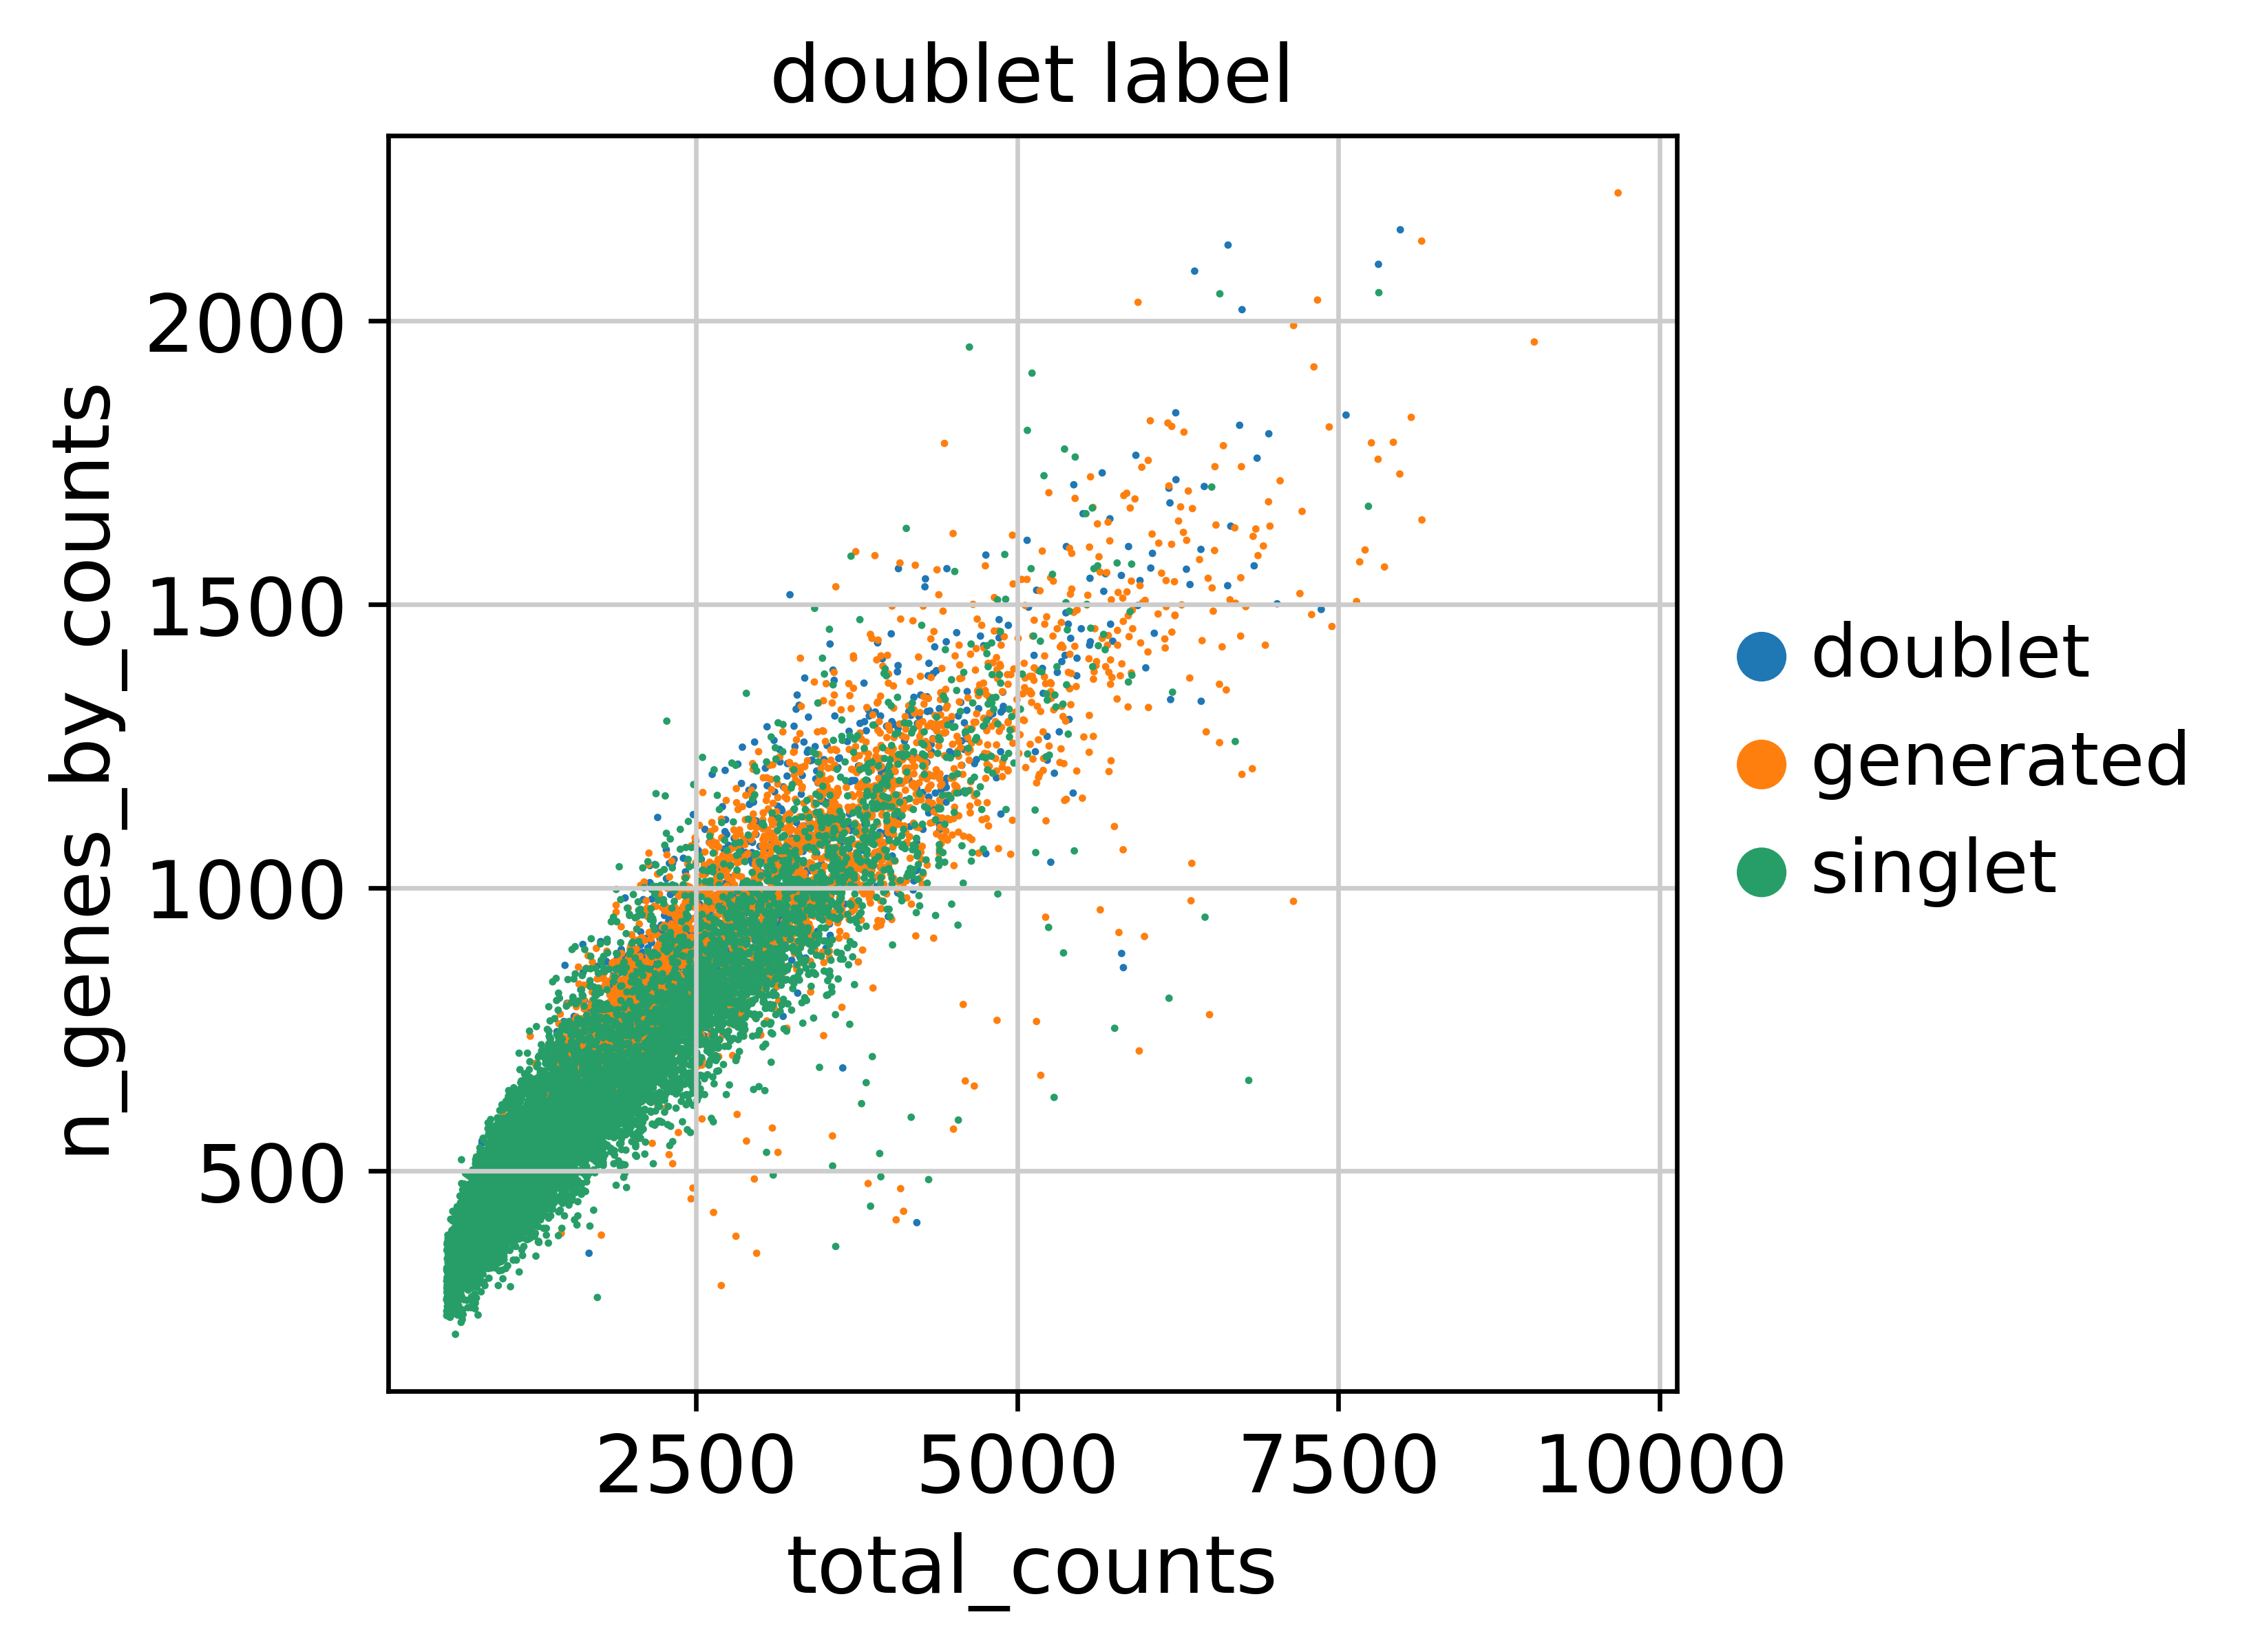

In [50]:
#adata_shuffled = adata[np.random.choice(adata.n_obs, adata.n_obs, replace = False)]
adata_shuffled = sc.pp.subsample(adata_merged, fraction = 1., copy = True)
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.scatter(adata_shuffled, x = 'total_counts', y = 'n_genes_by_counts', 
              color = 'doublet_label', ax=ax)
fig.savefig(fig_dir+'2.fake_doublets_scatter.png', bbox_inches='tight')
plt.show()

In [20]:
outdir = '/gpfs/gibbs/project/gerstein/cz357/23spring/2304_AAE/data/'
adata_merged.write_h5ad(outdir+'pbmc-2ctrl-dm-fake4000.h5ad.gz', compression='gzip')